In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import eig
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from umap import UMAP
from scipy.stats import norm
from scipy.special import kl_div
from scipy.stats import entropy
from scipy.spatial.distance import cdist 
import math
import time
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import datetime as dt
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import itertools
%matplotlib inline

In [2]:
orders = pd.read_csv("/Users/kalra/Documents/Northwestern/quarter2/421 Data Mining/assignments/assignment3/data/orders.csv")
customers = pd.read_csv("/Users/kalra/Documents/Northwestern/quarter2/421 Data Mining/assignments/assignment3/data/customers.csv")
products = pd.read_csv("/Users/kalra/Documents/Northwestern/quarter2/421 Data Mining/assignments/assignment3/data/Products.csv")

In [3]:
orders.shape

(75000, 5)

In [4]:
customers.shape

(1500, 3)

In [5]:
products.shape

(119, 3)

In [6]:
orders_products = pd.merge(orders, products, how = 'left') # Left join orders and products

In [7]:
orders_products_customers = pd.merge(orders_products, customers, how = 'left') # Now left join customers to the previous table

In [8]:
orders_products_customers.head(2)

,Date,CustomerId,ProductId,Quantity,Rating,ProductName,Price,name,address
0,1/1/2021,C925,P117,5,3.0,Wireless Headphones,150,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9..."
1,1/1/2021,C847,P35,4,5.0,Book,20,Adrian Jackson,"0008 Sally Circles,Nguyenview, WA 89950"


In [9]:
df = orders_products_customers.copy()

In [10]:
df.columns = df.columns.str.lower()

In [11]:
df['totalprice'] = df.price * df.quantity

# EDA

In [12]:
df.groupby('productname')['rating'].mean().sort_values(ascending = False).head(10) # Top 10 most rated product

productname
Resistance Bands    3.133690
Headphones          3.131907
Keychain            3.112245
Book                3.104283
Ski Goggles         3.099291
Card Game           3.091514
Smart TV            3.086176
Desktop Computer    3.084715
Backpack            3.083929
Chess Set           3.077990
Name: rating, dtype: float64

In [13]:
df.groupby('productname')['totalprice'].sum().sort_values(ascending = False).head(10) # Top 10 most sold product

productname
Laptop              3850800
Desktop Computer    3041000
Smart TV            2743200
Smart Phone         2448800
Gaming Console      1703000
Skis                1368400
Golf Club Set       1331600
Tablet              1254000
VR Headset          1072200
Snowboard           1066800
Name: totalprice, dtype: int64

In [14]:
pd.merge(df.groupby('customerid')['name'].count().sort_values(ascending = False).head(10), customers, left_index = True, right_on = 'CustomerId').loc[:, ['name_x', 'name_y']].rename(columns = {'name_x': 'count', 'name_y': 'name'}).sort_values(by = ['count'], ascending = False) # Top 10 most frequent customers

,count,name
14,81,Sonya Smith
1295,78,Emily Green
1495,75,Eric Williamson
1050,75,Howard Rivera
449,74,Karen Chambers
874,70,Carrie Johnson
761,70,Cindy Wallace
309,70,Bryan Buckley
1020,69,Michelle Grant
1411,69,Susan Ferrell


In [15]:
df.groupby('customerid')['name'].count().sum() # Total customers. Same as df.shape. Both are equivalent but this code line is more explanatory

75000

In [16]:
orders

,Date,CustomerId,ProductId,Quantity,Rating
0,1/1/2021,C925,P117,5,3.0
1,1/1/2021,C847,P35,4,5.0
2,1/1/2021,C399,P8,5,3.0
3,1/1/2021,C1231,P53,6,3.0
4,1/1/2021,C369,P44,8,4.0
...,...,...,...,...,...
74995,1/31/2022,C601,P71,3,2.0
74996,1/31/2022,C1297,P68,2,5.0
74997,1/31/2022,C760,P70,7,1.0
74998,1/31/2022,C1361,P9,8,4.0


In [17]:
pd.merge(df.groupby('customerid')['name'].count().sort_values(ascending = False).head(10) * 100 / 75000, customers, left_index = True, right_on = 'CustomerId').loc[:, ['name_x', 'name_y']].rename(columns = {'name_x': 'count', 'name_y': 'name'}).sort_values(by = ['count'], ascending = False) # Top 10 customers as a percentage of total orders

,count,name
14,0.108000,Sonya Smith
1295,0.104000,Emily Green
1495,0.100000,Eric Williamson
1050,0.100000,Howard Rivera
449,0.098667,Karen Chambers
874,0.093333,Carrie Johnson
761,0.093333,Cindy Wallace
309,0.093333,Bryan Buckley
1020,0.092000,Michelle Grant
1411,0.092000,Susan Ferrell


In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
# using customerid and date as unique order id

In [20]:
df['orderid'] = df.customerid + "_" + (df.date - dt.datetime(1970,1,1)).astype(str)

In [21]:
df.orderid

0         C925_18628 days
1         C847_18628 days
2         C399_18628 days
3        C1231_18628 days
4         C369_18628 days
               ...       
74995     C601_19023 days
74996    C1297_19023 days
74997     C760_19023 days
74998    C1361_19023 days
74999    C1138_19023 days
Name: orderid, Length: 75000, dtype: object

# RFM

Calculation of RFM metrics (recency, frequency, and monetary)
    
    recency = date of analysis - purchase date of the relevant customer
    frequency = customer's total number of purchases
    monetary = total monetary value as a result of the customer's total purchases
    
We will assume the date of analysis was 2 days after the max(date) in the dataset

In [22]:
df.sort_values(by='totalprice', ascending=False).head()

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid
63461,2021-12-01,C790,P1,9,2.0,Laptop,1200,Bruce Ray,"69785 Cuevas Lake Suite 256,Singhshire, AL 15555",10800,C790_18962 days
66543,2021-12-18,C838,P1,9,1.0,Laptop,1200,Destiny Velazquez,"75110 Scott Mills Suite 083,Daltonton, WI 32264",10800,C838_18979 days
5976,2021-02-01,C975,P1,9,4.0,Laptop,1200,Thomas Oneill,"1295 Sierra Estates Suite 171,Jessicamouth, NH...",10800,C975_18659 days
73130,2022-01-22,C1302,P1,9,4.0,Laptop,1200,Miss Christine Rodriguez,"133 Joshua Crescent,Jenniferland, MP 59745",10800,C1302_19014 days
42764,2021-08-14,C273,P1,9,4.0,Laptop,1200,David Phillips,"347 Torres Ferry Suite 412,Cisnerosmouth, MN 0...",10800,C273_18853 days


In [23]:
# get the total price paid per each invoice
# df.groupby('InvoiceNo').agg({'TotalPrice': 'sum'}).head().sort_values(by='TotalPrice', ascending=False)

# Cannot do the above as we don't have order id or invoice number here. Index can serve as proxy for that but then if index is used, what is the need to group by then. So we don't do this part

In [24]:
# get the last invoice date in the dataset
max_date = df['date'].max()
max_date

Timestamp('2022-01-31 00:00:00')

In [25]:
# adding a day to the calculated max date as date of analysis
snapshot = max_date + dt.timedelta(days = 1)
snapshot

Timestamp('2022-02-01 00:00:00')

In [26]:
# group the customer id's to see every single customer's activity on r, f , m
customer_group = df.groupby("customerid") 
customer_group.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",750,C925_18628 days
1,2021-01-01,C847,P35,4,5.0,Book,20,Adrian Jackson,"0008 Sally Circles,Nguyenview, WA 89950",80,C847_18628 days
2,2021-01-01,C399,P8,5,3.0,Women's Watch,150,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",750,C399_18628 days
3,2021-01-01,C1231,P53,6,3.0,Travel Pillow,20,Amanda Pena,"5823 Thompson Circles Suite 618,West Amy, HI 3...",120,C1231_18628 days
4,2021-01-01,C369,P44,8,4.0,Deodorant,5,Kelly Wood,"367 Hunt Ranch,Port Christopher, MP 13875",40,C369_18628 days
...,...,...,...,...,...,...,...,...,...,...,...
10990,2021-02-27,C1175,P67,5,2.0,Snowboard,350,Angel Li MD,"9651 Bailey Wall Apt. 353,Port Leonardmouth, M...",1750,C1175_18685 days
11009,2021-02-27,C987,P50,6,2.0,Coffee Mug,10,John Foster,"USNS Jensen,FPO AE 52486",60,C987_18685 days
11255,2021-02-28,C1072,P67,3,1.0,Snowboard,350,Patrick Lee,"41682 Moore Bridge Apt. 804,New Monica, TX 70895",1050,C1072_18686 days
12020,2021-03-04,C1175,P30,1,2.0,Suit,200,Angel Li MD,"9651 Bailey Wall Apt. 353,Port Leonardmouth, M...",200,C1175_18690 days


In [27]:
# the last day of grouped customer's transaction is captured with .max()
recency = (snapshot - customer_group["date"].max()) 

#how much total money has this customer spent
monetary = customer_group["totalprice"].sum()

# the first day of grouped customer's transaction is captured with .min()
tenure = snapshot - customer_group["date"].min() 

In [28]:
# how many times the customer made transactions?
frequency = customer_group["orderid"].nunique() 

In [29]:
r_idx = recency.index
m_idx = monetary.index
t_idx = tenure.index
f_idx = frequency.index

In [30]:
flag = True
# Group by and getting the values will give us values in sorted order of customer id. Frequency is not being created by a groupby object but a pd.DataFrame object and therefore index must be sorted. The below code just checks if the order of index in rfmt is in order and same otherwise rfm table values will be wrong
for r,m,t,f in zip(r_idx, m_idx, t_idx, f_idx):
    if r != m or r != t or r!= f or m != t or m!= f or t !=f:
        print("Index not in order. RFM table below will be wrong!!!")
        break
        flag = False
if flag:
    print("Index in order. RFM table will be ok")

Index in order. RFM table will be ok


In [31]:
# Create RFM table
# Groupby customer ID and aggregate on r, f, m,and t values

rfm = pd.DataFrame() 
rfm["Recency"] = recency.dt.days 
rfm["Frequency"] = frequency
rfm["Monetary"] = monetary
rfm["Tenure"] = tenure.dt.days 
rfm.head()

,Recency,Frequency,Monetary,Tenure
customerid,,,,
C0,4,56,21276,392
C1,13,40,23338,393
C10,29,52,23660,374
C100,4,46,15043,391
C1000,13,61,25293,393


In [32]:
#recency
rfm.Recency.describe()

count    1499.000000
mean        8.302201
std         7.714018
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        73.000000
Name: Recency, dtype: float64

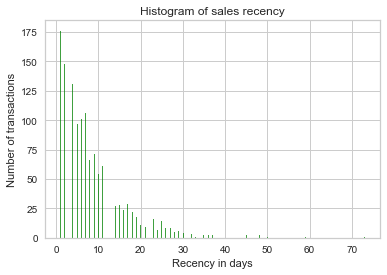

In [33]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 400, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)

In [34]:
rfm.reset_index(inplace = True)

In [35]:
customerid = rfm.customerid.values

In [36]:
#scale all RFMT values in the range 1-5
min_max_scaler = MinMaxScaler((1,5))
scaled = min_max_scaler.fit_transform(rfm[["Recency","Frequency","Monetary","Tenure"]])

In [37]:
scaled.shape

(1499, 4)

In [38]:
rfm = pd.DataFrame(scaled, columns=rfm.columns[1:])

In [39]:
# rfm['customerid'] = customerid

In [40]:
rfm.head()

,Recency,Frequency,Monetary,Tenure
0,1.166667,3.511628,2.063444,4.719298
1,1.666667,2.023256,2.220400,4.789474
2,2.555556,3.139535,2.244910,3.456140
3,1.166667,2.581395,1.589001,4.649123
4,1.666667,3.976744,2.369210,4.789474


/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/k

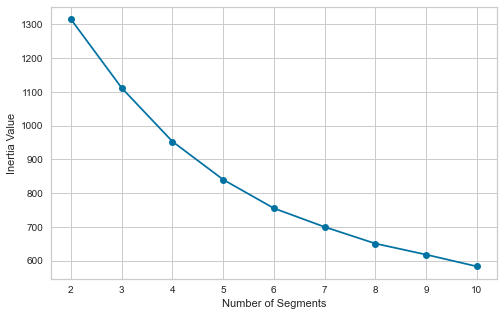

In [41]:
X = rfm.values 
n_cluster = range(2, 11, 1)
cost = []

for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=13)
    model.fit(X)
    cost.append(model.inertia_)
    
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, cost, marker="o")
ax.set_xlabel("Number of Segments")
ax.set_ylabel("Inertia Value")
plt.show()

In [42]:
#k=3 probably gets better clusters, however the business would like to see 6 groups
n_cluster = 6

model = KMeans(n_clusters=n_cluster, random_state=2023)
y = model.fit_predict(rfm[["Recency","Frequency","Monetary","Tenure"]])

rfm["Segment"] = y

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [43]:
rfm['Recency'] = 1/rfm.Recency # Professor told to take inverse based on definition

In [44]:
rfm['customerid'] = customerid

In [45]:
rfm.head() 

,Recency,Frequency,Monetary,Tenure,Segment,customerid
0,0.857143,3.511628,2.063444,4.719298,1,C0
1,0.600000,2.023256,2.220400,4.789474,4,C1
2,0.391304,3.139535,2.244910,3.456140,5,C10
3,0.857143,2.581395,1.589001,4.649123,4,C100
4,0.600000,3.976744,2.369210,4.789474,1,C1000


In [46]:
#lets take a look at each segment in terms of RFMT
rfm.groupby("Segment").mean()

,Recency,Frequency,Monetary,Tenure
Segment,,,,
0,0.793892,3.388640,3.367521,4.593455
1,0.794275,3.141552,2.159122,4.685447
2,0.423501,2.360261,2.138987,4.674361
3,0.773365,2.464607,2.814568,4.671149
4,0.798503,2.125255,1.763353,4.607879
5,0.778394,2.485465,2.272387,3.505482


0.35 weight for recency

0.30 weight for frequency

0.35 weight for monetary

This weighted score is used to form the categories for the customers

In [47]:
rfm["Score"] = 0.35*rfm['Recency'] + 0.3*rfm['Frequency'] + 0.35*rfm['Monetary']

In [48]:
#lets take a look at each segment in terms of RFMT
rfm.groupby("Segment").mean().sort_values(by = [('Score')], ascending = False)

,Recency,Frequency,Monetary,Tenure,Score
Segment,,,,,
0,0.793892,3.388640,3.367521,4.593455,2.473087
3,0.773365,2.464607,2.814568,4.671149,1.995159
1,0.794275,3.141552,2.159122,4.685447,1.976154
5,0.778394,2.485465,2.272387,3.505482,1.813413
2,0.423501,2.360261,2.138987,4.674361,1.604949
4,0.798503,2.125255,1.763353,4.607879,1.534226


In [49]:
humanization = {0: "Platinum", 1: "Gold", 2: "Bronze", 3: "Diamond", 4: "Risk of churn", 5: "Silver"}
rfm["Segment"].replace(humanization,inplace=True)
rfm.head()

,Recency,Frequency,Monetary,Tenure,Segment,customerid,Score
0,0.857143,3.511628,2.063444,4.719298,Gold,C0,2.075694
1,0.600000,2.023256,2.220400,4.789474,Risk of churn,C1,1.594117
2,0.391304,3.139535,2.244910,3.456140,Silver,C10,1.864535
3,0.857143,2.581395,1.589001,4.649123,Risk of churn,C100,1.630569
4,0.600000,3.976744,2.369210,4.789474,Gold,C1000,2.232247


In [50]:
rfm

,Recency,Frequency,Monetary,Tenure,Segment,customerid,Score
0,0.857143,3.511628,2.063444,4.719298,Gold,C0,2.075694
1,0.600000,2.023256,2.220400,4.789474,Risk of churn,C1,1.594117
2,0.391304,3.139535,2.244910,3.456140,Silver,C10,1.864535
3,0.857143,2.581395,1.589001,4.649123,Risk of churn,C100,1.630569
4,0.600000,3.976744,2.369210,4.789474,Gold,C1000,2.232247
...,...,...,...,...,...,...,...
1494,0.857143,2.581395,1.772445,4.087719,Risk of churn,C995,1.694774
1495,0.900000,2.953488,1.622645,4.228070,Gold,C996,1.768972
1496,0.900000,2.488372,2.721408,3.807018,Silver,C997,2.014004
1497,1.000000,2.674419,2.646584,4.578947,Diamond,C998,2.078630


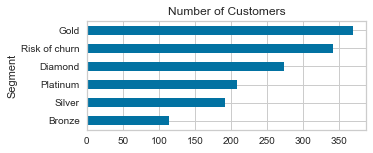

In [51]:
#group by topic and plot rows in the descending order
rfm.groupby('Segment').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

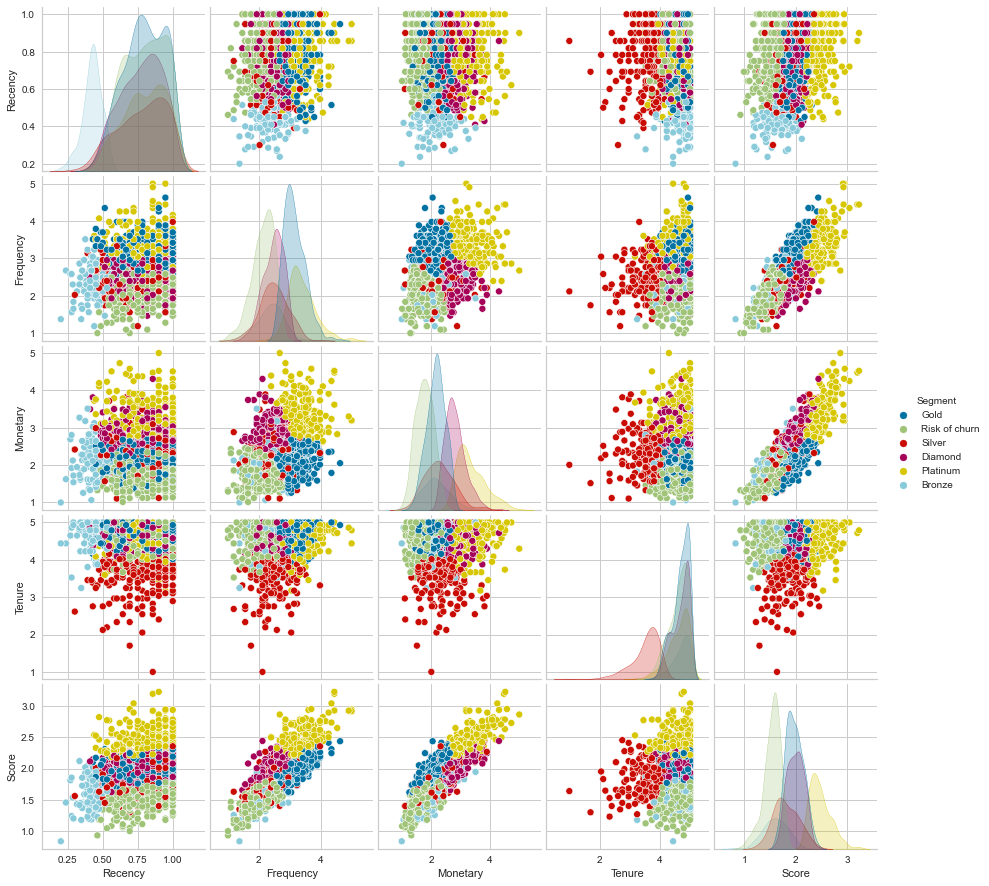

In [52]:
sns.pairplot(rfm, hue="Segment")
plt.show()

###  RFM Score (Clustering Alternative)
Score = (Recency score x Recency weight) + (Frequency score x Frequency weight) + (Monetary score x Monetary weight).

0.35 weight for recency

0.30 weight for frequency

0.35 weight for monetary

In [53]:
std_scaler = StandardScaler()
std_score = std_scaler.fit_transform(rfm[["Score"]])
rfm['Std_Score'] = std_score
rfm.head(2)

,Recency,Frequency,Monetary,Tenure,Segment,customerid,Score,Std_Score
0,0.857143,3.511628,2.063444,4.719298,Gold,C0,2.075694,0.506298
1,0.600000,2.023256,2.220400,4.789474,Risk of churn,C1,1.594117,-0.871118


In [54]:
rfm.describe()

,Recency,Frequency,Monetary,Tenure,Score,Std_Score
count,1499.000000,1499.000000,1499.000000,1499.000000,1499.000000,1.499000e+03
mean,0.761133,2.676777,2.369287,4.500392,1.898680,1.376114e-16
std,0.174387,0.599193,0.649387,0.512612,0.349740,1.000334e+00
min,0.200000,1.000000,1.000000,1.000000,0.831628,-3.052002e+00
25%,0.642857,2.209302,1.890657,4.298246,1.641275,-7.362344e-01
50%,0.782609,2.674419,2.282892,4.649123,1.875712,-6.569296e-02
75%,0.900000,3.046512,2.762892,4.859649,2.124079,6.446895e-01
max,1.000000,5.000000,5.000000,5.000000,3.230970,3.810640e+00


# Market Basket Analysis

Consolidate the items into **1 transaction per row** with each product 1 hot encoded. 

In [55]:
df.columns

Index(['date', 'customerid', 'productid', 'quantity', 'rating', 'productname',
       'price', 'name', 'address', 'totalprice', 'orderid'],
      dtype='object')

In [56]:
basket = (df.groupby(['orderid', 'productid'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('orderid'))

In [57]:
basket.head()

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
orderid,,,,,,,,,,,,,,,,,,,,,
C0_18632 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0_18644 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0_18647 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0_18649 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0_18650 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
basket.shape

(70491, 118)

In [59]:
basket.columns

Index(['P1', 'P10', 'P100', 'P101', 'P102', 'P103', 'P104', 'P105', 'P106',
       'P107',
       ...
       'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P96', 'P97', 'P98', 'P99'],
      dtype='object', name='productid', length=118)

In [60]:
basket.head(2)

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
orderid,,,,,,,,,,,,,,,,,,,,,
C0_18632 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C0_18644 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
def encode_units(x):
    if x >= 1:
        return 1
    else:
        return 0

#convert each value into 0 or 1
basket_sets = basket.applymap(encode_units)

In [62]:
basket_sets.head(2)

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
orderid,,,,,,,,,,,,,,,,,,,,,
C0_18632 days,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C0_18644 days,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#How many items in each transaction
df2 = basket_sets.sum(numeric_only = True, axis=1).reset_index(name ='ItemCount')

In [64]:
df2.head()

,orderid,ItemCount
0,C0_18632 days,1
1,C0_18644 days,1
2,C0_18647 days,1
3,C0_18649 days,1
4,C0_18650 days,1


In [65]:
df2.sort_values(by = ['ItemCount'], ascending = False)

,orderid,ItemCount
30504,C235_18780 days,4
47917,C567_18737 days,4
30120,C228_18733 days,4
62226,C843_18675 days,3
12176,C1233_18906 days,3
...,...,...
24270,C1465_18730 days,1
24271,C1465_18736 days,1
24272,C1465_18738 days,1
24273,C1465_18739 days,1


In [66]:
df2.ItemCount.value_counts()

1    66185
2     4138
3      165
4        3
Name: ItemCount, dtype: int64

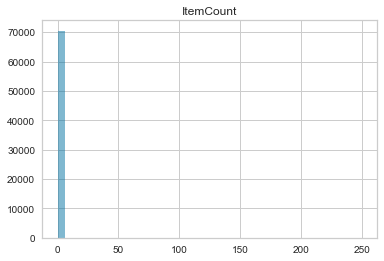

In [67]:
df2.hist(alpha=0.5, range=[0, 250], bins=40) # Most are near 1 to as shown by value counts()
plt.show()

# Apriori on the dataset

Doesn't work and kernel keeps on breaking. Used fp-growth thence

In [68]:
# No country here or any other valid subset to look into
# basket1 = (df[df['Country'] =="France"]
#           .groupby(['InvoiceNo', 'Description'])['Quantity']
#           .sum().unstack().reset_index().fillna(0)
#           .set_index('InvoiceNo'))

We can generate frequent item sets that have a support of at least x%:

In [69]:
# support = 0.001 ==> 118 items
# support = 0.0001 ==> 118 items
# support = 0.00001 ==> Kernel breaks
# support = 0.000001 ==> Kernel breaks
# support = 0.0000001 ==> Kernel breaks

# with support value that does works, the association rules are an empty object. In the original notebook, we subset by country and then do the below process but here we have nothing akin to country to subset on

In [70]:
# #set thresholds for support, lift and confidence
# min_support = 0.0000001
# min_lift = 0.1
# min_confidence = 0.1

In [71]:
# frequent_itemsets1 = apriori(basket_sets, min_support=min_support, use_colnames=True)

In [72]:
# display(frequent_itemsets1.head(10))
# print(f"The total number of items using the min_support = {min_support} is {frequent_itemsets1.shape[0]}")

In [73]:
# rules = association_rules(frequent_itemsets1, metric="lift", min_threshold=0.000000000000001)
# rules.head()

In [74]:
# rules[ (rules['lift'] >= min_lift) &
#        (rules['confidence'] >= min_confidence) ]

# FPGrowth on the dataset

In [75]:
# support = 0.001 ==> 118 items
# support = 0.0001 ==> 118 items
# support = 0.00001 ==> 3689 items
# support = 0.000001 ==> 3689 items
# support = 0.00000001 ==> 3689 items
# support = 0.000000001 ==> 3689 items
# support = 0.0000000001 ==> 3689 items
# support = 0.00000000001 ==> 3689 items
# support = 0.000000000001 ==> 3689 items

# with support value that does works, the association rules are an empty object. In the original notebook, we subset by country and then do the below process but here we have nothing akin to country to subset on

In [76]:
min_support_fp = 0.00001

In [77]:
frequent_itemsets2 = fpgrowth(basket_sets, min_support = min_support_fp, use_colnames = True)
frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [78]:
display(frequent_itemsets2)

,support,itemsets,length
0,0.008994,(P30),1
1,0.008966,(P18),1
2,0.009335,(P82),1
3,0.008441,(P34),1
4,0.009420,(P93),1
...,...,...,...
3684,0.000014,"(P58, P84, P37)",3
3685,0.000014,"(P58, P103, P17)",3
3686,0.000014,"(P58, P4, P100)",3
3687,0.000014,"(P58, P113, P46)",3


In [79]:
print(f"The total number of items using the min_support = {min_support_fp} is {frequent_itemsets2.shape[0]}")

The total number of items using the min_support = 1e-05 is 3689


In [80]:
frequent_itemsets2.length.value_counts(dropna = False, sort = True, ascending = False)

2    3391
3     177
1     118
4       3
Name: length, dtype: int64

In [81]:
two_itemsets = frequent_itemsets2[(frequent_itemsets2['length'] == 2) &
                   (frequent_itemsets2['support'] >= 0.00008) ]
two_itemsets

,support,itemsets,length
2747,0.000085,"(P49, P68)",2


In [82]:
names_pd_series_holder = []
for idx, item in enumerate(two_itemsets["itemsets"].values):
    names_list = ', '.join((products[products["ProductId"].isin(item)]["ProductName"].values))
    names_pd_series_holder.append(names_list)

In [83]:
two_itemsets['items_name'] = names_pd_series_holder

/var/folders/cn/lmyg_r6n1pb0srcgmqvgxdgh0000gn/T/ipykernel_52747/811317099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_itemsets['items_name'] = names_pd_series_holder


In [84]:
two_itemsets.sort_values(by = "support", ascending = False, inplace = True)

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [85]:
two_itemsets

,support,itemsets,length,items_name
2747,0.000085,"(P49, P68)",2,"Shower Gel, Snow Boots"


In [1]:
three_itemsets = frequent_itemsets2[(frequent_itemsets2['length'] == 3) &
                   (frequent_itemsets2['support'] >= 0.000014) ]

NameError: name 'frequent_itemsets2' is not defined

In [87]:
names_pd_series_holder = []
for idx, item in enumerate(three_itemsets["itemsets"].values):
    names_list = ', '.join((products[products["ProductId"].isin(item)]["ProductName"].values))
    names_pd_series_holder.append(names_list)

In [88]:
three_itemsets['items_name'] = names_pd_series_holder

/var/folders/cn/lmyg_r6n1pb0srcgmqvgxdgh0000gn/T/ipykernel_52747/4120238849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_itemsets['items_name'] = names_pd_series_holder


In [89]:
three_itemsets.sort_values(by = "support", ascending = False, inplace = True)

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [90]:
three_itemsets

,support,itemsets,length,items_name
147,0.000014,"(P30, P52, P102)",3,"Suit, Water Bottle, Badminton Racket"
1958,0.000014,"(P53, P78, P56)",3,"Travel Pillow, Neck Pillow, Resistance Bands"
2419,0.000014,"(P79, P111, P86)",3,"Dumbbell Set, Weightlifting Belt, Jigsaw Puzzle"
2420,0.000014,"(P79, P55, P115)",3,"Passport Holder, Dumbbell Set, Video Game Console"
2421,0.000014,"(P112, P111, P79)",3,"Dumbbell Set, Jigsaw Puzzle, Rubik's Cube"
...,...,...,...,...
1295,0.000014,"(P61, P96, P83)",3,"Hat, Pull-Up Bar, Golf Balls"
1398,0.000014,"(P50, P101, P26)",3,"Running Shoes, Coffee Mug, Volleyball Net"
1469,0.000014,"(P88, P12, P116)",3,"Desktop Computer, Baseball Glove, Video Game"
1470,0.000014,"(P81, P12, P43)",3,"Desktop Computer, Conditioner, Foam Roller"


In [91]:
frequent_itemsets2[(frequent_itemsets2['length'] == 3)].shape

(177, 3)

In [92]:
frequent_itemsets2[(frequent_itemsets2['length'] == 3)].support.value_counts()

0.000014    177
Name: support, dtype: int64

In [93]:
frequent_itemsets2[(frequent_itemsets2['length'] == 2)].shape

(3391, 3)

In [94]:
rules = association_rules(frequent_itemsets2, metric="lift", min_threshold=100)

In [95]:
rules.sort_values(by = ['lift', 'confidence'], ascending = False, inplace = True)

In [96]:
# converting product id to pro
antecedents_pd_series_holder = []
consequents_pd_series_holder = []
for idx, item in enumerate(rules["antecedents"].values):
    names_list = ', '.join((products[products["ProductId"].isin(item)]["ProductName"].values))
    antecedents_pd_series_holder.append(names_list)
for idx, item in enumerate(rules["consequents"].values):
    names_list = ', '.join((products[products["ProductId"].isin(item)]["ProductName"].values))
    consequents_pd_series_holder.append(names_list)

In [97]:
rules['antecedents'] = antecedents_pd_series_holder
rules['consequents'] = consequents_pd_series_holder

In [98]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
244,"Sneakers, Passport Holder","Fitness Tracker, Weightlifting Belt",0.000014,0.000014,0.000014,1.00000,70491.000000,0.000014,inf
249,"Fitness Tracker, Weightlifting Belt","Sneakers, Passport Holder",0.000014,0.000014,0.000014,1.00000,70491.000000,0.000014,inf
278,"Scarf, Shuttlecock","Women's Watch, Gaming Headset",0.000014,0.000014,0.000014,1.00000,70491.000000,0.000014,inf
283,"Women's Watch, Gaming Headset","Scarf, Shuttlecock",0.000014,0.000014,0.000014,1.00000,70491.000000,0.000014,inf
544,"Smart TV, Game Controller","Printer, Lip Balm",0.000014,0.000014,0.000014,1.00000,70491.000000,0.000014,inf
...,...,...,...,...,...,...,...,...,...
215,Rain Boots,"Gaming Console, Chess Set",0.009987,0.000014,0.000014,0.00142,100.129261,0.000014,1.001408
351,Rain Boots,"Dress Shirt, Book",0.009987,0.000014,0.000014,0.00142,100.129261,0.000014,1.001408
371,Rain Boots,"Laptop, Baseball Glove",0.009987,0.000014,0.000014,0.00142,100.129261,0.000014,1.001408
387,Rain Boots,"Basketball, Tennis Balls",0.009987,0.000014,0.000014,0.00142,100.129261,0.000014,1.001408


# Recommendation System

### Popularity Based  Recommender

Pick the most popular products (rated highly) among the users and directly recommend those

In [99]:
df.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",750,C925_18628 days
1,2021-01-01,C847,P35,4,5.0,Book,20,Adrian Jackson,"0008 Sally Circles,Nguyenview, WA 89950",80,C847_18628 days


In [100]:
products.head(2)

,ProductId,ProductName,Price
0,P1,Laptop,1200
1,P2,Smart TV,900


In [101]:
pd.merge(df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}).sort_values(by = [('rating', 'mean'), ('orderid', 'count')], ascending = False), products, left_index = True, right_on = 'ProductId').rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'rating'})[['count', 'rating', 'ProductName']].head(10) # Top 10 products based on average rating

/var/folders/cn/lmyg_r6n1pb0srcgmqvgxdgh0000gn/T/ipykernel_52747/424338852.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  pd.merge(df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}).sort_values(by = [('rating', 'mean'), ('orderid', 'count')], ascending = False), products, left_index = True, right_on = 'ProductId').rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'rating'})[['count', 'rating', 'ProductName']].head(10) # Top 10 products based on average rating


,count,rating,ProductName
77,619,3.133690,Resistance Bands
2,626,3.131907,Headphones
58,665,3.112245,Keychain
34,584,3.104283,Book
64,621,3.099291,Ski Goggles
109,663,3.091514,Card Game
1,610,3.086176,Smart TV
11,622,3.084715,Desktop Computer
35,620,3.083929,Backpack
107,633,3.077990,Chess Set


### Collaborative Filter   

In [102]:
df.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",750,C925_18628 days
1,2021-01-01,C847,P35,4,5.0,Book,20,Adrian Jackson,"0008 Sally Circles,Nguyenview, WA 89950",80,C847_18628 days


In [103]:
# Build the user-item matrix
user_item = pd.pivot_table(data=df, values='rating', index='customerid', columns='productid')
user_item.replace('',np.nan,inplace=True) 
user_item.head()

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
customerid,,,,,,,,,,,,,,,,,,,,,
C0,NaN,NaN,1.0,3.5,NaN,NaN,1.5,NaN,NaN,3.0,...,4.0,NaN,NaN,2.0,5.0,NaN,5.0,NaN,NaN,NaN
C1,NaN,NaN,2.5,NaN,NaN,NaN,NaN,2.0,NaN,3.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,5.0
C10,NaN,5.0,5.0,1.0,4.0,3.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
C100,NaN,NaN,4.5,NaN,NaN,NaN,NaN,5.0,3.0,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
C1000,5.0,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,NaN,...,2.0,NaN,5.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN


In [104]:
# Normalize user-item matrix
user_item_norm = user_item.subtract(user_item.mean(axis=1), axis = 0)
user_item_norm.head()

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
customerid,,,,,,,,,,,,,,,,,,,,,
C0,NaN,NaN,-2.019380,0.480620,NaN,NaN,-1.519380,NaN,NaN,-0.01938,...,0.980620,NaN,NaN,-1.01938,1.980620,NaN,1.980620,NaN,NaN,NaN
C1,NaN,NaN,-0.196970,NaN,NaN,NaN,NaN,-0.696970,NaN,0.30303,...,NaN,NaN,NaN,1.30303,NaN,NaN,NaN,NaN,1.303030,2.303030
C10,NaN,1.837037,1.837037,-2.162963,0.837037,-0.162963,-2.162963,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.837037,-0.162963
C100,NaN,NaN,1.302632,NaN,NaN,NaN,NaN,1.802632,-0.197368,NaN,...,NaN,-0.197368,NaN,NaN,NaN,NaN,NaN,NaN,-0.197368,NaN
C1000,1.836538,NaN,NaN,NaN,NaN,1.836538,NaN,-1.163462,NaN,NaN,...,-1.163462,NaN,1.836538,NaN,-2.163462,NaN,-1.163462,NaN,NaN,NaN


In [105]:
# User similarity matrix using Pearson correlation
user_similarity = user_item_norm.T.corr(method='pearson')
user_similarity.head()

customerid,C0,C1,C10,C100,C1000,C1001,C1002,C1003,C1004,C1005,...,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999
customerid,,,,,,,,,,,,,,,,,,,,,
C0,1.000000,-0.337984,-0.202985,-0.154626,-0.378079,0.211027,-0.016615,0.217219,-0.092647,0.146720,...,-0.626949,-0.034092,-0.111671,1.278370e-01,-0.133586,0.186383,-0.088992,-0.590610,-0.377785,0.161514
C1,-0.337984,1.000000,0.574002,-0.173809,-0.014481,-0.560691,-0.342246,0.269871,0.098514,-0.699548,...,-0.289999,-0.044392,0.616908,-3.778059e-02,-0.170959,0.392229,-0.011543,0.286661,0.400520,-0.100301
C10,-0.202985,0.574002,1.000000,0.198286,-0.114076,-0.368564,-0.065722,-0.068524,0.282120,-0.217074,...,0.044057,0.019434,0.053109,1.975892e-17,0.509006,0.095209,-0.051498,-0.102091,0.235901,-0.320375
C100,-0.154626,-0.173809,0.198286,1.000000,0.253177,-0.162527,-0.349547,-0.600005,0.162985,0.029401,...,-0.443172,-0.508428,0.277200,1.436401e-01,-0.587282,0.359983,-0.070173,-0.179286,-0.130032,0.256439
C1000,-0.378079,-0.014481,-0.114076,0.253177,1.000000,0.196019,-0.104037,0.027056,0.486517,0.129806,...,-0.118079,-0.088217,0.008687,-1.181054e-01,-0.232340,0.237609,0.036610,-0.047522,-0.149962,-0.100415


In [106]:
# Item similarity matrix using Pearson correlation
item_similarity = user_item_norm.corr(method='pearson')
item_similarity.head()

productid,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
productid,,,,,,,,,,,,,,,,,,,,,
P1,1.000000,-0.034998,0.028720,-0.071083,-0.168742,-0.100842,0.040354,0.061726,0.004292,-0.100190,...,-0.076181,0.004436,-0.021076,-0.058462,-0.039329,-0.097933,-0.153579,0.023724,-0.020249,0.029783
P10,-0.034998,1.000000,-0.079982,-0.103309,-0.142319,0.059390,0.043308,-0.096742,-0.044121,-0.145192,...,-0.044291,-0.166434,0.088960,0.010738,0.170965,-0.136498,-0.053775,-0.005359,-0.078501,-0.065213
P100,0.028720,-0.079982,1.000000,-0.025076,0.014898,-0.071237,-0.137048,0.012991,0.026807,-0.114120,...,0.102712,-0.073014,0.056096,-0.054195,0.050790,0.032011,0.036536,-0.093442,-0.080829,0.034228
P101,-0.071083,-0.103309,-0.025076,1.000000,-0.048248,0.025537,-0.005357,-0.122432,-0.017808,-0.082539,...,-0.049516,0.163355,0.018384,-0.038795,-0.000764,-0.123402,-0.022679,-0.165060,-0.057354,-0.074353
P102,-0.168742,-0.142319,0.014898,-0.048248,1.000000,-0.071463,0.003089,-0.041725,-0.061732,0.069929,...,-0.021545,0.066159,-0.037115,-0.025913,0.029533,-0.066507,-0.080088,-0.028561,-0.088075,0.037154


In [107]:
# # Pick a user ID
target_userid = 'C760' 

# # Pick a book
target_bookid = 'P10'

# # Books that the target user has rated
target_userid_rated = pd.DataFrame(user_item_norm.loc[[target_userid]].dropna(axis=1, how='all')).reset_index()
target_userid_rated.drop(target_userid_rated.iloc[:, 0:1], inplace=True, axis=1)
target_userid_rated = target_userid_rated.T
target_userid_rated.head()

,0
productid,
P101,2.39899
P109,-0.10101
P112,-0.10101
P113,2.39899
P115,0.39899


In [108]:
# # Similarity score of the target_bookid with all the other books
target_book_similarity_score = item_similarity.loc[[target_bookid]].dropna(axis=1, how='all').reset_index()
target_book_similarity_score.drop(target_book_similarity_score.iloc[:, 0:1], inplace=True, axis=1)
target_book_similarity_score = target_book_similarity_score.T
target_book_similarity_score.head()

,0
productid,
P1,-0.034998
P10,1.000000
P100,-0.079982
P101,-0.103309
P102,-0.142319


In [109]:
# #Rank the similarities between the books 
target_book_similarity = target_book_similarity_score.sort_values(by = [(0)], ascending = False)

In [110]:
target_book_similarity = target_book_similarity.iloc[1:, :] # Drop the first row as it is the product itself therefore the max score of 1.00

In [111]:
# #Rank the similarities between target user and target book
target_userid_rated_similarity = target_book_similarity#select top 5

In [112]:
target_book_similarity = target_book_similarity.rename(columns = {(0) : ('similarity_score')})

In [113]:
target_userid_rated_similarity = pd.merge(pd.merge(df[['customerid', 'productid', 'rating']], df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}), how = 'left', left_on = 'productid', right_index = True).rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'mean_rating'}), target_book_similarity, how = 'right', left_on = 'productid', right_index = True)

/var/folders/cn/lmyg_r6n1pb0srcgmqvgxdgh0000gn/T/ipykernel_52747/1071908187.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  target_userid_rated_similarity = pd.merge(pd.merge(df[['customerid', 'productid', 'rating']], df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}), how = 'left', left_on = 'productid', right_index = True).rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'mean_rating'}), target_book_similarity, how = 'right', left_on = 'productid', right_index = True)


In [114]:
# #Calculate the predicted rating using weighted average of similarity
predicted_rating = round(np.average(target_userid_rated_similarity['mean_rating'], 
                                    weights=target_userid_rated_similarity['similarity_score']), 6)
print(f'The predicted rating for {target_bookid} by user {target_userid} is {predicted_rating}' )

The predicted rating for P10 by user C760 is 3.04027


### Scikit based Recommender 

Surprise is a scikit-based like libraries to develop recommender systems using explicit rating data. 

Surprise provides several algorithms to develop collaborative filtering recommender systems, starting from memory-based method (i.e. K-Nearest Neighbors or KNN) to model-based method (i.e. Singular Value Decomposition or SVD).

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

In [116]:
ratings = df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']})

In [117]:
ratings[('rating', 'mean')].min()

2.8694096601073347

In [118]:
# Get minimum and maximum rating from the dataset
min_rating = ratings[('rating', 'mean')].min()
max_rating = ratings[('rating', 'mean')].max()

In [119]:
reader = Reader(rating_scale=(min_rating, max_rating))

In [120]:
df.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid
0,2021-01-01,C925,P117,5,3.0,Wireless Headphones,150,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",750,C925_18628 days
1,2021-01-01,C847,P35,4,5.0,Book,20,Adrian Jackson,"0008 Sally Circles,Nguyenview, WA 89950",80,C847_18628 days


In [121]:
df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}).head(2)

,orderid,rating
,count,mean
productid,,
P1,646,2.996587
P10,632,2.932990


In [122]:
_temp = pd.merge(df[['customerid', 'productid', 'rating']], df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}), how = 'left', left_on = 'productid', right_index = True).rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'mean_rating'})

/var/folders/cn/lmyg_r6n1pb0srcgmqvgxdgh0000gn/T/ipykernel_52747/2560806426.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  _temp = pd.merge(df[['customerid', 'productid', 'rating']], df.groupby('productid').agg({'orderid': ['count'], 'rating': ['mean']}), how = 'left', left_on = 'productid', right_index = True).rename(columns = {('orderid', 'count'): 'count', ('rating', 'mean'): 'mean_rating'})


In [123]:
_temp = _temp[~_temp['rating'].isna()] # Drop null ratings

In [124]:
_temp

,customerid,productid,rating,count,mean_rating
0,C925,P117,3.0,612,3.052158
1,C847,P35,5.0,584,3.104283
2,C399,P8,3.0,653,3.011765
3,C1231,P53,3.0,612,3.019366
4,C369,P44,4.0,627,3.050260
...,...,...,...,...,...
74995,C601,P71,2.0,606,2.956044
74996,C1297,P68,5.0,675,2.930081
74997,C760,P70,1.0,654,2.970149
74998,C1361,P9,4.0,639,3.041451


In [125]:
data = Dataset.load_from_df(_temp[['customerid', 'productid', 'rating']], reader)

### Matrix Factorization


In [126]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.4185  1.4107  1.4258  1.4346  1.4273  1.4133  1.4198  1.4115  1.4306  1.4181  1.4210  0.0078  
MAE (testset)     1.2181  1.2122  1.2249  1.2392  1.2285  1.2128  1.2223  1.2147  1.2362  1.2172  1.2226  0.0090  
Fit time          0.17    0.17    0.17    0.17    0.17    0.17    0.16    0.16    0.16    0.16    0.17    0.01    
Test time         0.03    0.02    0.02    0.02    0.02    0.03    0.02    0.02    0.02    0.02    0.02    0.00    


In [127]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  1.222614926681014
Average RMSE:  1.4210087461644898


### Hyperparameter Tuning

Additionally, we can also conduct hyperparameter tuning to obtain the best hyperparameters for our model. In this case, we use grid search cross-validation in hyperparameter tuning.

In [128]:
param_grid = {
  'n_factors': [20, 50, 70, 100],
  'n_epochs': [5, 10, 20]
}
 
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)
 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.4206534944341365
{'n_factors': 20, 'n_epochs': 5}


### Model Retraining

After the best hyperparameters are obtained, we can retrain the model using these hyperparameter.

In [129]:
# best hyperparameters
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']
 
# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)
 
# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

### Recommendation

In [130]:
def get_recommendations(model, ratings_df, products, user_id, product_id_col_name, user_id_col_name, product_name_col, product_df_product_id_col_name):
    product_ids = _temp[product_id_col_name].unique()

    # Get a list of all items that have been rated by user
    product_ids_user = _temp.loc[_temp[user_id_col_name] == user_id, product_id_col_name]

    # Get a list off all items that that have not been not rated by user
    product_ids_to_pred = np.setdiff1d(product_ids, product_ids_user)

    # Apply a rating of 4 to all interactions (only to match the Surprise dataset format)
    test_set = [[user_id, product_id, 4] for product_id in product_ids_to_pred]

    # Predict the ratings and generate recommendations
    predictions = model.test(test_set)

    pred_ratings = np.array([pred.est for pred in predictions])

    print("Top {0} item recommendations for user {1}:\n".format(n_items, user_id))

    # Rank top-n items based on the predicted ratings
    index_max = (-pred_ratings).argsort()[:n_items]
    for i in index_max:
        product_id = product_ids_to_pred[i]
        print(products[products[product_df_product_id_col_name]==product_id][product_name_col].values[0], '\t', pred_ratings[i])
    

### Recommendations

In [131]:
# define which user ID that we want to give recommendation
user_id = 'C760'

# define how many top-n movies that we want to recommend
n_items = 10

product_id_col_name = 'productid'
user_id_col_name = 'customerid'
product_name_col = 'ProductName'
product_df_product_id_col_name = 'ProductId'

get_recommendations(svd, _temp, products, user_id, product_id_col_name, user_id_col_name, product_name_col, product_df_product_id_col_name)

Top 10 item recommendations for user C760:

Resistance Bands 	 3.059260170074736
Game Controller 	 3.0064658249355904
Razor 	 2.9885740883487215
Sweatpants 	 2.966955334728951
Ping Pong Balls 	 2.9402146758415486
Travel Pillow 	 2.9255047719167666
Soccer Ball 	 2.9247080696525503
Toothbrush 	 2.9228749239058724
Dress Shirt 	 2.9207141711256677
Card Game 	 2.9185694276731344


# Strategies for clusters of customers

Discounts + recommendations for different clusters + promotions + better placement of products + marketing (emails)

In [132]:
df = pd.merge(df, rfm[["Segment", "Score", "Std_Score", "customerid"]], how = 'left', on = 'customerid') # Get segment for every customers after merging

In [133]:
at_risk = df[df['Segment'] == 'Risk of churn']

In [134]:
at_risk.sort_values(by = "Score", ascending = False, inplace = True) # Get the best customers in the subset which are at the risk of churn and give them discounts, promotions, and great product recommendations

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [135]:
# Get 10 unique customers which have the highest probability of being saved [highest score] and therefore can give them discounts, promotions and product recommendations
rescue_n = 10
customers_to_rescue = at_risk.customerid.unique()[:rescue_n]

In [136]:
customers_to_rescue

array(['C148', 'C598', 'C1466', 'C1358', 'C700', 'C112', 'C1460', 'C859',
       'C703', 'C1461'], dtype=object)

In [137]:
# Giving predictions to the customers at risk. We can offer them discounts and promotions for them
for customer in customers_to_rescue:
    get_recommendations(svd, _temp, products, customer, product_id_col_name, user_id_col_name, product_name_col, product_df_product_id_col_name)

Top 10 item recommendations for user C148:

Laptop 	 3.1336898395721926
Tote Bag 	 3.1336898395721926
T-shirt 	 3.1336898395721926
Toothbrush 	 3.1336898395721926
Deodorant 	 3.1336898395721926
Golf Club Set 	 3.1336898395721926
Razor 	 3.1336898395721926
Hand Sanitizer 	 3.1336898395721926
Dress Shirt 	 3.1336898395721926
Coffee Mug 	 3.1336898395721926
Top 10 item recommendations for user C598:

Game Controller 	 3.1336898395721926
Headphones 	 3.1336898395721926
Blanket 	 3.1336898395721926
Dress Shoes 	 3.1336898395721926
Men's Watch 	 3.1336898395721926
Running Shoes 	 3.1336898395721926
Smart TV 	 3.1336898395721926
Leather Belt 	 3.1336898395721926
Resistance Bands 	 3.1336898395721926
Chess Set 	 3.1336898395721926
Top 10 item recommendations for user C1466:

Headphones 	 3.126202172500825
Blanket 	 3.0886080004433154
Ski Goggles 	 3.085737986038574
Chess Set 	 3.085181463331842
Yoga Mat 	 3.08502174610264
Snow Jacket 	 3.0814320288706716
Book 	 3.0639480221587423
Shampoo 	 3.0

In [139]:
platinum = df[df['Segment'] == "Platinum"]

In [141]:
platinum.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid,Segment,Score,Std_Score
11,2021-01-01,C795,P90,9,2.0,Soccer Ball,30,Phillip Barr,"6858 Horn Parks Apt. 224,South Charleschester,...",270,C795_18628 days,Platinum,2.328453,1.229243
12,2021-01-01,C1064,P47,7,5.0,Lip Balm,2,John Hoover,"00357 Shawn Heights Apt. 022,Kevinview, MT 36858",14,C1064_18628 days,Platinum,2.655379,2.164325


We can offer loyalty programs to our platinum customers to make sure that they are satisfied and keep with us and don't churn

In [144]:
gold = df[df['Segment'] == "Gold"]

In [146]:
gold.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid,Segment,Score,Std_Score
2,2021-01-01,C399,P8,5,3.0,Women's Watch,150,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",750,C399_18628 days,Gold,1.911488,0.036633
3,2021-01-01,C1231,P53,6,3.0,Travel Pillow,20,Amanda Pena,"5823 Thompson Circles Suite 618,West Amy, HI 3...",120,C1231_18628 days,Gold,1.854000,-0.127796


In [150]:
gold = pd.merge(gold, products[['ProductName', 'ProductId']], how = 'left', left_on = 'productid', right_on = 'ProductId')

In [157]:
gold.sort_values(by = 'Score', ascending = False, inplace = True) # best gold tier customers

In [158]:
gold.head(2)

,date,customerid,productid,quantity,rating,productname,price,name,address,totalprice,orderid,Segment,Score,Std_Score,ProductName,ProductId
16375,2021-11-16,C449,P50,6,4.0,Coffee Mug,10,Karen Chambers,"641 Kyle Lake,Jamesport, VT 19235",60,C449_18947 days,Gold,2.438027,1.54265,Coffee Mug,P50
845,2021-01-15,C449,P118,6,3.0,Bluetooth Speaker,100,Karen Chambers,"641 Kyle Lake,Jamesport, VT 19235",600,C449_18642 days,Gold,2.438027,1.54265,Bluetooth Speaker,P118


In [160]:
gold_n = 10
best_gold_customers = gold['customerid'].unique()[:gold_n] # Get best 10 gold customers

In [162]:
customer = best_gold_customers[0]

In [171]:
rules.head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
244,"Sneakers, Passport Holder","Fitness Tracker, Weightlifting Belt",0.000014,0.000014,0.000014,1.0,70491.0,0.000014,inf


In [198]:
rules.antecedents.str.split(', ').str.len().value_counts(sort = True, ascending = False)

2    285
1    279
3     12
Name: antecedents, dtype: int64

In [174]:
ants = rules.antecedents.values

In [175]:
cons = rules.consequents.values

In [212]:
recommendation_dict = {}

In [213]:
# Creating a dictionary of dictionary of dictionary that will hold the consequents
for a, c in zip(ants, cons):
    items_a = a.split(', ')
    try:
        for perm in (list(itertools.permutations(items_a))):
            for idx, item in enumerate(perm):
                if len(perm) == 3: # 3 item antecedent
                    if idx == 0:
                        recommendation_dict[item] = {}
                    elif idx == 2: # last item
                        recommendation_dict[perm[0]][perm[1]][item] = c
                    else:
                        recommendation_dict[perm[0]][item] = {}
                elif len(perm) == 2:
                    if idx == 0:
                        recommendation_dict[item] = {}
                    else:
                        recommendation_dict[perm[0]][item] = c
                else:
                    recommendation_dict[item] = c
    except TypeError:
        print('Error occured for')
        print(a)
        print(c)
        break

In [224]:
recommendations = {}
for customer in best_gold_customers:
    recommendations[customer] = {1: [], 2: [], 3: []}
    for idx, ant in enumerate(list(gold[gold['customerid'] == customer]['ProductName'].values)):
        if ant in recommendation_dict:
            if type(recommendation_dict[ant]) == str:
                recommendations[customer][1].append(recommendation_dict[ant])
            else:
                for idx2, ant2 in enumerate(list(gold[gold['customerid'] == customer]['ProductName'].values)[idx + 1:]):
                    if ant2 in recommendation_dict[ant]:
                        if type(recommendation_dict[ant][ant2]) == str:
                            recommendations[customer][2].append(recommendation_dict[ant][ant2])
                        else:
                            for idx3, ant3 in enumerate(list(gold[gold['customerid'] == customer]['ProductName'].values)[idx2 + 1:]):
                                if ant3 in recommendation_dict[ant][ant2]:
                                    if type(recommendation_dict[ant][ant2]) == str:
                                        recommendations[customer][3].append(recommendation_dict[ant][ant2][ant3])            

In [225]:
recommendations # Print product recommendations

{'C449': {1: ['Soccer Cleats, Card Game',
   'Soccer Cleats, Card Game',
   'Dress Shoes, Dumbbell Set',
   'Scarf, Jigsaw Puzzle',
   'Skis, Resistance Bands',
   "Shuttlecock, Rubik's Cube",
   'Smart TV, Playing Cards',
   'Desktop Computer, Deodorant',
   'Hoodie, Snowboard',
   'Sunglasses, Scarf',
   'Umbrella, Jump Rope',
   'Wallet, Jigsaw Puzzle',
   'Dress Shoes, Dumbbell Set',
   "Men's Watch, Beach Towel",
   'Skis, Resistance Bands',
   'Tablet, Gloves',
   'Scarf, Jigsaw Puzzle',
   'Dumbbell Set, Baseball Glove'],
  2: ['Badminton Racket',
   'Soap',
   'Passport Holder',
   'Desktop Computer',
   'Bluetooth Speaker',
   'Running Shirt',
   'Soap'],
  3: []},
 'C387': {1: ['Wallet, Punching Bag',
   'Smart TV, Playing Cards',
   'Tablet, Gloves',
   'Umbrella, Jump Rope',
   'Dress Shoes, Dumbbell Set',
   'Toothbrush, Shuttlecock',
   'Soccer Cleats, Card Game',
   'Toothbrush, Shuttlecock',
   'Skis, Resistance Bands',
   'Sunglasses, Scarf',
   'Running Shorts, Video 